# Milestone 2 - Data collection and description
The second task is to intimately acquaint yourself with the data, preprocess it and complete all the necessary descriptive statistics tasks. We expect you to have a pipeline in place, fully documented in a notebook, and show us that you’ve advanced with your understanding of the project goals by updating its README description.

In [1]:
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
import json
import seaborn as sns
from IPython.display import IFrame
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import findspark
findspark.init()

import pyspark

conf = pyspark.SparkConf()\
    .setMaster('local[*]')\
    .set('spark.executor.memory', '2g')\
    .set('spark.driver.memory', '2g')\
    .set('spark.executor.instances', '4')
    
sc = pyspark.SparkContext(conf=conf)

# Gaining insight into the Amazon product network 

## Overview

The Amazon dataset contains relations among products, such as "also viewed", "also bought", "bought together", "bought after viewing". These links can be used to create a graph that represents products with similar characteristics, that is, products that are viewed together but not bought together.
Our idea is to exploit the dataset in order to create clusters of competing products. These clusters may be used not only to identify the best product in terms of rating and sales within a group, but also to investigate how brands can influence the sales and the prices of similar products.

The dataset is transformed into a graph of relations between products, where the vertices represent products, and edges represent competition between products. For instance, if two products are viewed together (people who viewed product A also viewed product B, and vice versa) but not bought together, they are competitors. On the other hand, two products that are viewed together and bought together are not competitors (e.g. a user buys a smartphone and a cover). A way of expressing this in more formal terms is with max-cliques, that is, finding sets of vertices that are totally interconnected.

## Dataset description

The Amazon dataset consists of two JSON files: 
- *metadata.json*: contains information about the products, such as their unique ID, description and price. The size of the dataset is 9.81 GB (uncompressed, in JSON format).
- *reviews.json*: contains reviews and ratings associated with each product, as well as the helpfulness of each review. The size of the dataset is approximately 87 GB (again, uncompressed and in JSON format).

Since the dataset does not fit in memory, we cannot process it using libraries such as Pandas, unless we reduce its size first.
Therefore, the initial data processing was carried out using **PySpark**, both on the cluster (especially for the reviews dataset) and in local. While it may seem inappropriate at first, using Spark in local makes sense for medium-sized datasets (like the metadata one), as it automatically parallelizes jobs using all cores, and spills to disk intermediate results that cannot fit in main memory.

### Metadata
The dataset contains a list of entries of products with the following fields (some of them may be missing):
- **asin**: unique ID of the product.
- **title**: name of the product.
- **price**: price in US dollars.
- **imUrl**: URL of the product image.
- **related**: related products, which contains the sub-lists: *also bought, also viewed, bought together, buy after viewing*.
- **salesRank**: sales rank information, i.e. how well the product compares to other products in the same category in terms of sales.
- **brand**: brand name.
- **categories**: the category(-ies) to which the product belongs.

These fields are already sufficient for building our graph, since they contain the above-mentioned relations between products, as well as their IDs and names. Here we present an example of such a record:

In [12]:
sc.textFile('data/metadata.json')\
    .map(lambda x: ast.literal_eval(x))\
    .filter(lambda x: 'price' in x and 'related' in x)\
    .take(1)

[{'asin': '0000143561',
  'categories': [['Movies & TV', 'Movies']],
  'description': '3Pack DVD set - Italian Classics, Parties and Holidays.',
  'imUrl': 'http://g-ecx.images-amazon.com/images/G/01/x-site/icons/no-img-sm._CB192198896_.gif',
  'price': 12.99,
  'related': {'also_viewed': ['B0036FO6SI',
    'B000KL8ODE',
    '000014357X',
    'B0037718RC',
    'B002I5GNVU',
    'B000RBU4BM'],
   'buy_after_viewing': ['B0036FO6SI',
    'B000KL8ODE',
    '000014357X',
    'B0037718RC']},
  'salesRank': {'Movies & TV': 376041},
  'title': 'Everyday Italian (with Giada de Laurentiis), Volume 1 (3 Pack): Italian Classics, Parties, Holidays'}]

Note that we had to use `ast.literal_eval` instead of the JSON library because the dataset is not in standard JSON format. It appears to be in Python's `print() ` format.

Before moving forward, we have to decide whether it makes sense to carry out our analysis on the whole dataset, or if it is more appropriate to select only a subset of all categories. It turns out that the latter is the case: sales in categories such as **Music**, **Books**, or **Clothes** depend on people's personal preferences, and are less (if not at all) prone to competition. On the contrary, electronic products are the ones that are subject to real competition, as clients wants to get the best possible product at the lowest cost. Moreover, this selection step allows us to reduce the size of the dataset and process it more efficiently.

Therefore, the first step consists in listing all categories and selecting those in which we are interested. As can be seen from the example above, categories are represented as hierarchies, e.g. `["Sports & Outdoors", "Other Sports", "Dance"]` means that the product can be found in the category **Sports & Outdoors -> Other Sports -> Dance**. Firstly, we extract the list of macro-categories (top-level categories such as **Sports & Outdoors**) along with their product count, and we inspect them manually. Our goal is to choose macro-categories containing products that can be objectively compared in terms of features and characteristics, such as *Electronics* or *Cell phones*. Converseley, categories of which the purchase decision is subjective (e.g. clothes and books) are discarded.

In [13]:
# Get all top-level categories along with their product count
categories_macro = sc.textFile('data/metadata.json')\
    .map(lambda x: ast.literal_eval(x))\
    .filter(lambda x: 'categories' in x)\
    .flatMap(lambda x: x['categories'])\
    .map(lambda x: x[0])\
    .map(lambda x: (x, 1))\
    .reduceByKey(lambda x, y: x + y)\
    .collect()

In [19]:
# We show the top categories sorted by product count
df = pd.DataFrame(categories_macro)
df.columns = ['category', 'count']
df.sort_values('count', ascending=False).head(30)

,category,count
49,"Clothing, Shoes & Jewelry",3429257
13,Books,2855617
66,CDs & Vinyl,1523001
30,Kindle Store,1088341
72,Sports & Outdoors,543514
73,Electronics,500600
52,Home & Kitchen,437019
32,Cell Phones & Accessories,357693
36,Toys & Games,336460
9,Automotive,331484


According to our considerations, we decided to include the following macro categories in our analysis: **Electronics**, **Cell Phones & Accessories**, **Automotive**, **Tools & Home Improvement**, and **Musical Instruments**. The choice is motivated both by their sizes and by the fact that they represent products that are comparable.

Now, we want to have a more detailed description of the categories. Therefore, for each macro-category, we convert the category lists within each product to a tree. We do this in a distributed way, using Spark. The job works as follows:
- **Map phase:** each list is converted to a tree. For instance:

In [883]:
# Transforms a category list into a flat tree (a tree with a linked list topology)
def convert_to_tree(elements):
    root = {}
    node = root
    for element in elements:
        node[element] = (1, {}) # Tuple: (product count, children)
        node = node[element][1]
    return root

In [884]:
convert_to_tree(["Sports & Outdoors", "Other Sports", "Dance"])

{'Sports & Outdoors': (1, {'Other Sports': (1, {'Dance': (1, {})})})}

Each category includes the product count along with its subcategories (children). The product count within a category includes the sum of the product counts of all its children.

- **Reduce phase:** all trees are merged together recursively, creating a huge category tree that reflects the entire dataset.

In [885]:
# Merge nodes
def merge_trees(a, b):
    for key in b:
        if key in a:
            a[key] = (a[key][0] + b[key][0], a[key][1])
            merge_trees(a[key][1], b[key][1])
        else:
            a[key] = b[key]
    return a

In [123]:
# Example
a = convert_to_tree(["Sports & Outdoors", "Other Sports", "Dance"])
b = convert_to_tree(["Sports & Outdoors", "Supplies"])
merge_trees(a, b)

{'Sports & Outdoors': (2,
  {'Other Sports': (1, {'Dance': (1, {})}), 'Supplies': (1, {})})}

Now we run the actual job on Spark.

In [39]:
# Top-level categories of interest
categories_to_extract = set(['Electronics', 'Cell Phones & Accessories', 'Automotive',\
                             'Tools & Home Improvement', 'Musical Instruments'])

# Build the category tree
category_tree = sc.textFile('data/metadata.json')\
    .map(lambda x: ast.literal_eval(x))\
    .filter(lambda x: 'categories' in x)\
    .flatMap(lambda x: x['categories'])\
    .filter(lambda x: x[0] in categories_to_extract)\
    .map(convert_to_tree)\
    .reduce(merge_trees)

In the example below, the subtree of *Cell Phones & Accessories* is shown, along with product count for each sub-category. As can be seen, sub categories may differ significantly in terms of belonging products. Therefore, some heuristics may be necessary to group together categories that contains a small number of products.

In [33]:
# Each node represents a (count, children) tuple
category_tree['Cell Phones & Accessories']

(357693,
 {'Accessories': (109763,
   {'Accessory Kits': (26545, {}),
    'Audio Adapters': (497, {}),
    'Batteries': (9882,
     {'Battery Charger Cases': (560, {}),
      'External Battery Packs': (2079, {}),
      'Internal Batteries': (6651, {})}),
    'Bluetooth Speakers': (782, {}),
    'Car Accessories': (5863,
     {'Car Cradles & Mounts': (4705,
       {'Car Cradles': (424, {}), 'Car Mounts': (4189, {})}),
      'Car Kits': (845, {}),
      'Car Speakerphones': (312, {})}),
    'Chargers': (17463,
     {'Car Chargers': (7650, {}),
      'Cell Phone Docks': (1894, {}),
      'International Chargers': (169, {}),
      'Solar Chargers': (284, {}),
      'Travel Chargers': (7122, {})}),
    'Cradles, Mounts & Stands': (48, {'Stands': (47, {})}),
    'Data Cables': (6671, {}),
    'Headsets': (10197,
     {'Bluetooth Headsets': (5066, {}), 'Wired Headsets': (5023, {})}),
    'Phone Charms': (3073, {}),
    'Replacement Parts': (6592, {}),
    'SIM Cards & Tools': (506, {}),
    '

We made an interactive visualization using the 5 macro-categories that we selected. This allowed us to explore the tree and see its overall structure, as the number of sub-categories is too high for being inspected textually. You can see it [here](https://niccolosacchi.github.io/categories-graph.html).

### Reviews

The reviews dataset (`reviews.json`) has a size of approximately 87 GB. Each review contains the following fields:
- **reviewerID**: unique ID associated to each user.
- **asin**: unique ID associated to each product.
- **reviewerName**: name of the user.
- **helpful**: helpfulness rating of the review (tuple of 2 elements: "A out of B find this review helpful").
- **reviewText**: text of the review.
- **overall**: rating of the product from 1 to 5 stars.
- **summary** - summary of the review.
- **unixReviewTime** - unix timestamp of the review.
- **reviewTime** - raw timestamp of the review.

Since our project is mainly focused on products, we are not interested in *individual* reviews. However, we still need this dataset in order to compute the aggregate ratings for each product and merge them into our dataset.

## Preliminary processing

#### Reduce the Amazon dataset

Due to the large size of the Amazon dataset, we decided to create a custom dataset prior to performing any further analysis. The custom dataset, which has been named *reduced*, contains only products belonging to the macro-categories selected in the previous parapraph. In addition, the review ratings of each product are averaged and merged with the products. As a result, we obtain a smaller *metadata* dataset (1.71 GB) that is enriched with the average product rating field, as well as with the reviews count and their helpfulness.

##### Aggregate ratings
The average product rating is computed from the data in the *reviews* dataset. For each entry, the product ID and the rating are stored, respectively, in the *asin* and *overall* fields. To compute the rating, entries are grouped by product ID and then 
averaged on the *overall* field. In addition to the average rating for each product, we add some extra information which might come handy later: the number of reviews (`num_reviews`), and the ratio of helpful reviews (`helpful_fraction`).
The output is saved in JSON format as `aggregate_ratings.json`. The code for processing the data (shown below) was executed on the ADA cluster.

```python
import json
import pyspark.sql.functions as func
from pyspark import SparkContext
from pyspark.sql import SQLContext

sc = SparkContext()
sqlContext = SQLContext(sc)

rdd = sc.textFile('/datasets/productGraph/complete.json')\
    .map(lambda x: json.loads(x))\
    .map(lambda x: (x['asin'], x['overall'], x['helpful'][0], x['helpful'][1]))

sqlContext.createDataFrame(rdd, ['asin', 'overall', 'helpful_positive', 'helpful_all'])\
    .groupBy('asin')\
    .agg(
        func.mean('overall').alias('average_rating'),
        func.count('overall').alias('num_reviews'),
        (func.sum('helpful_positive') / func.sum('helpful_all')).alias('helpful_fraction')
    )\
    .toJSON()\
    .saveAsTextFile('aggregate_ratings.json')
```

##### Merge the datasets
*Metadata* is filtered so as to mantain only the products belonging to the macro categories of interest, which are then merged with *aggregate_ratings*. The code that generates the *reduced* dataset is shown below. An important observation is that a product can belong to multiple categories (`categories` is a list of lists). However, in our merging process, we need to assign a product to only one category to avoid duplicates. After some investigation, we decided to empirically re-assign products only to the first one in order of appearance, as often the other ones were the result of crawling errors or were inappropriate.

```python
# The list of macro categories that we want to extract
categories_to_extract = set(['Electronics', 'Cell Phones & Accessories', 'Automotive',\
                             'Tools & Home Improvement', 'Musical Instruments'])

# Extract macro category
def extract_category(x):
    x['category'] = x['categories'][0]
    del x['categories']
    x['num_reviews'] = 0 # The number of reviews is 0 in the default case
    if 'salesRank' in x:
        # Convert the dictionary to a more suitable format (tuple)
        if len(x['salesRank']) > 0:
            x['salesRank'] = list(next(iter(x['salesRank'].items())))
        else:
            del x['salesRank'] # Remove malformed fields (i.e. empty dictionaries)
    return x

# Load the aggregate ratings
ratings = sc.textFile('data/aggregate_ratings.json')\
    .map(lambda x: json.loads(x))\
    .map(lambda x: (x['asin'], x))

# Filter products and merge datasets.
# Note that we use the left outer join, so as to include products that have no reviews.
sc.textFile('data/metadata.json')\
    .map(lambda x: ast.literal_eval(x))\
    .filter(lambda x: 'categories' in x)\
    .map(extract_category)\
    .filter(lambda x: x['category'][0] in categories_to_extract)\
    .map(lambda x: (x['asin'], x))\
    .leftOuterJoin(ratings)\
    .map(lambda x: x[1])\
    .map(lambda x: x[0] if x[1] == None else {**x[0], **x[1]})\
    .map(lambda x: json.dumps(x))\
    .saveAsTextFile('data/reduced.json')
```

In [856]:
# The list of macro categories that we want to extract
categories_to_extract = set(['Electronics', 'Cell Phones & Accessories', 'Automotive',\
                             'Tools & Home Improvement', 'Musical Instruments'])

# Extract macro category
def extract_category(x):
    x['category'] = x['categories'][0]
    del x['categories']
    x['num_reviews'] = 0 # The number of reviews is 0 in the default case
    if 'salesRank' in x:
        # Convert the dictionary to a more suitable format (tuple)
        if len(x['salesRank']) > 0:
            x['salesRankCat'] = next(iter(x['salesRank'].keys()))
            x['salesRankPos'] = next(iter(x['salesRank'].values()))
        del x['salesRank']
    
    # Change the format of the relations to a simpler one:
    # instead of having nested fields, everything is in the top level.
    # Additionally, missing relations are converted to empty lists,
    # so that they do not need to be checked later.
    x['buy_after_viewing'] = []
    x['bought_together'] = []
    if 'related' in x:
        if 'buy_after_viewing' in x['related']:
            x['buy_after_viewing'] = x['related']['buy_after_viewing']
        if 'bought_together' in x['related']:
            x['bought_together'] = x['related']['bought_together']
        del x['related']
        
    return x

# Load the aggregate ratings
ratings = sc.textFile('data/aggregate_ratings.json')\
    .map(lambda x: json.loads(x))\
    .map(lambda x: (x['asin'], x))

# Filter products and merge datasets.
# Note that we use the left outer join, so as to include products that have no reviews.
sc.textFile('data/metadata.json')\
    .map(lambda x: ast.literal_eval(x))\
    .filter(lambda x: 'categories' in x)\
    .map(extract_category)\
    .filter(lambda x: x['category'][0] in categories_to_extract)\
    .map(lambda x: (x['asin'], x))\
    .leftOuterJoin(ratings)\
    .map(lambda x: x[1])\
    .map(lambda x: x[0] if x[1] == None else {**x[0], **x[1]})\
    .map(lambda x: json.dumps(x))\
    .saveAsTextFile('data/reduced.json')

##  Exploratory data analysis

### Missing data statistics
As first thing, we want to see which fields can be missing, and, should they be, the actual fraction of missing values. In order to do this, we sample a subset of the dataset (25%) using Spark, and we process it with Pandas. This will not affect the result considerably, as the sampled dataset is still huge.

In [781]:
sample = sc.textFile('data/reduced.json')\
    .sample(fraction=0.25, withReplacement=False)\
    .map(lambda x: json.loads(x))\
    .collect()

In [782]:
df = pd.DataFrame(sample)
df.head()

,asin,average_rating,brand,category,description,helpful_fraction,imUrl,num_reviews,price,related,salesRankCat,salesRankPos,title
0,0558835155,3.000000,NaN,"[Electronics, Accessories & Supplies, Audio & ...",Use these high quality headphones for internet...,NaN,http://ecx.images-amazon.com/images/I/21rEirnd...,1,13.95,NaN,NaN,NaN,Polaroid Pbm2200 PC / Gaming Stereo Headphones...
1,9868238854,5.000000,NaN,"[Musical Instruments, Band & Orchestra, Wind &...",Woodnote Tenor Recorder was made of High perf...,1.000000,http://ecx.images-amazon.com/images/I/51h8cIN5...,2,61.41,"{'also_bought': ['078661790X', 'B001LQW2KI', '...",Musical Instruments,60253.0,Woodnote Wood Grain Tenor Recorder-Baroque fin...
2,9966569863,4.205128,SanDisk,"[Electronics, Computers & Accessories, Cables ...",Professional Ultra SanDisk MicroSDXC 32GB (32 ...,0.666667,http://ecx.images-amazon.com/images/I/41MDVeln...,39,14.75,"{'also_bought': ['B002PAX9QU', 'B00AAIPT76', '...",Cell Phones & Accessories,3165.0,Professional Ultra SanDisk MicroSDHC 32GB (32 ...
3,B00000J4EY,4.739130,Kensington,"[Electronics, Computers & Accessories, Cables ...",SmartSockets Table Top features circular desig...,0.772021,http://ecx.images-amazon.com/images/I/518XPAS3...,69,44.15,"{'also_bought': ['B000BN9VLK', 'B000BN9VKQ', '...",NaN,NaN,Kensington 62634 SmartSockets 6-Outlet 16 feet...
4,B00002230Y,4.166667,NaN,"[Tools & Home Improvement, Power & Hand Tools,...",The DeWalt DW7440 table saw stand delivers the...,0.727273,http://ecx.images-amazon.com/images/I/41JDNrU0...,6,63.11,"{'also_viewed': ['B000J46C18', 'B0019VKEM8', '...",NaN,NaN,DEWALT DW7440 Table Saw Stand


asin                0.000000
average_rating      0.000003
brand               0.625581
category            0.000000
description         0.072916
helpful_fraction    0.505774
imUrl               0.001439
num_reviews         0.000000
price               0.178937
related             0.249818
salesRankCat        0.617327
salesRankPos        0.617327
title               0.009839
dtype: float64


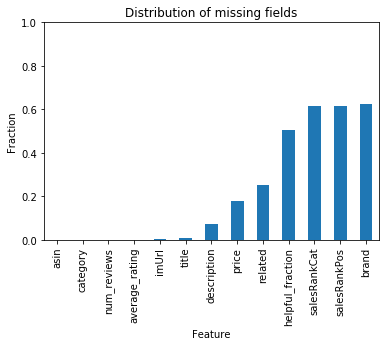

In [783]:
missing_stats = df.isnull().sum()/len(df)
print(missing_stats)
pd.DataFrame(missing_stats).sort_values(0).plot.bar(title="Distribution of missing fields", legend=None)
plt.ylim(0, 1)
plt.ylabel('Fraction')
_ = plt.xlabel('Feature')

The results are mixed:
- The ID (`asin`) and the categories are always present by definition.
- Almost all articles have at least one review (non-null `average_rating`).
- The title can be missing at times, although this is very rare.
- The price and textual description can be missing with a low probability.
- The sales rank and the brand are missing in most cases (about 60% of cases).

### Distributions of features
We now proceed by analyzing the statistics of numeric fields. This might give us some useful insights.

In [768]:
df.describe()

,average_rating,helpful_fraction,num_reviews,price
count,377878.000000,187113.000000,377880.000000,310421.000000
mean,3.950019,0.791048,14.414677,55.285248
std,1.148420,0.281694,120.135435,105.791165
min,1.000000,0.000000,0.000000,0.000000
25%,3.333333,0.678571,1.000000,7.910000
50%,4.200000,0.900000,2.000000,17.990000
75%,5.000000,1.000000,5.000000,50.500000
max,5.000000,1.000000,19146.000000,999.990000


From these basic statistics, we can observe that:
- The average ratings tend to be high.
- The distribution of the number of reviews for each article is heavy-tailed (the mean is much larger than the median).
- Most reviews are regarded as helpful (50% of the articles have an helpfulness percentage greater than 90%), meaning that we can take them into account with good confidence.

Additionally, we plot the distribution of the average ratings.

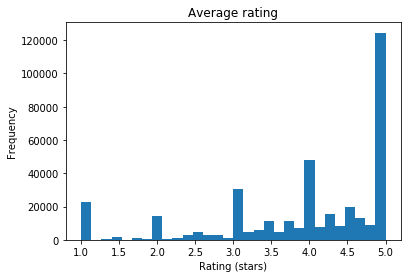

In [769]:
df['average_rating'].plot.hist(title='Average rating', bins=30)
plt.xlabel('Rating (stars)')

As can be seen from the histogram plot above, the ratings are concentrated near integer values. This is due to the fact that most articles contain a small number of reviews (in most cases, only one), and they strongly bias the distribution. Earlier, we observed that the distribution of the *number of reviews* feature is heavy-tailed. To illustrate this clearly, we plot it below.

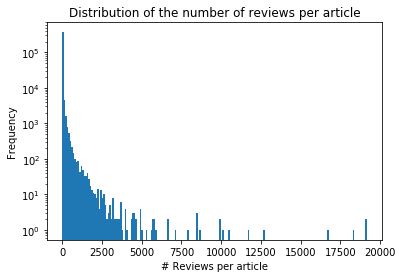

In [770]:
df['num_reviews'].plot.hist(bins=200, log=True, title='Distribution of the number of reviews per article')
plt.xlabel('# Reviews per article')

This indeed confirms our hypothesis. Note that we plotted our histogram in logarithmic scale. The majority of articles contain a very small number of reviews, but there are some outliers that are reviewed a huge number of times.

We plot again the histogram of the average rating per article, but this time we weigh each record according to the number of reviews of the corresponding record.

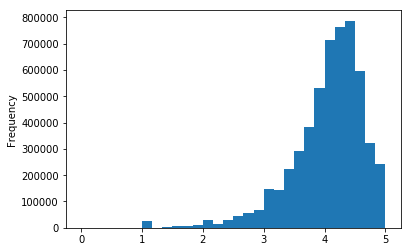

In [771]:
df['average_rating'].fillna(0).plot.hist(weights = df['num_reviews'], bins=30)

This result is much smoother and reflects reality. As can be seen, users tend to be very "generous" when reviewing products.

We also plot the distribution of the article prices:

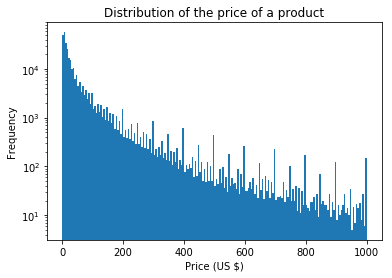

In [772]:
df['price'].plot.hist(bins=200, log=True, title='Distribution of the price of a product')
plt.xlabel('Price (US $)')

Again, we plotted the histogram in log-scale, which reveals that prices are as well distributed according to a heavy-tailed distribution. We can also observe another important detail: the price seems truncated to 1000 dollars (this is also reflected in the summary statistics, which show that the maximum price is 999.99). This seems to be wrong, as the real Amazon website shows products that are well above 1000 dollars as price.
To verify whether this is caused by some error in our analysis, we double-check this fact on the original, full dataset.

In [89]:
sc.textFile('data/metadata.json')\
    .map(lambda x: ast.literal_eval(x))\
    .filter(lambda x: 'price' in x and x['price'] > 999.99)\
    .count()

0

Our supposition was correct: the prices are truncated at 999.99 at the source.

### Correlation analysis
We perform some basic correlation analysis on the sampled dataset, without splitting the categories. Specifically, we investigate the correlations among price, review rating and sales rank, hoping to find some patterns in the distribution of these variables.

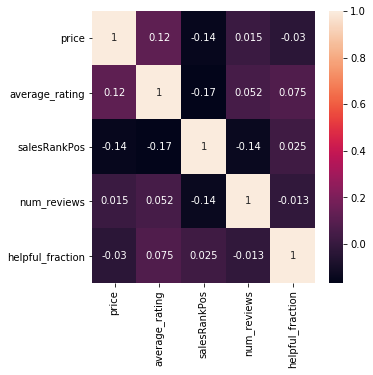

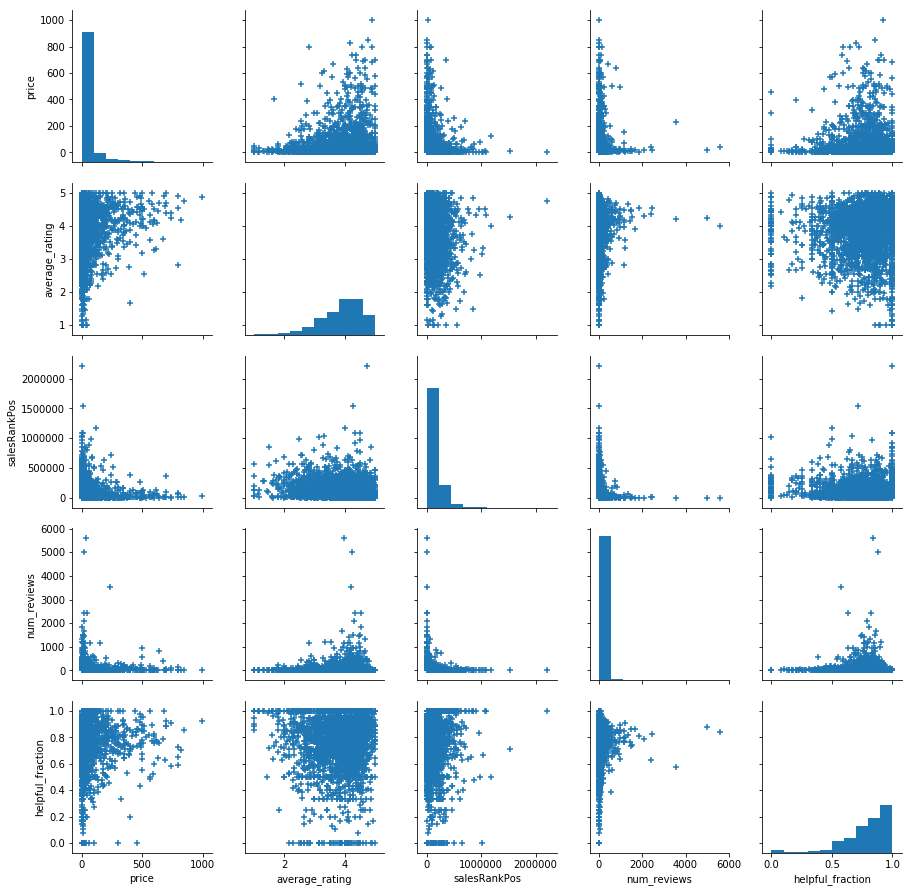

In [785]:
df_corr = df[df['num_reviews'] > 5] # We select only product with more than 5 reviews
df_corr = df_corr[['price', 'average_rating', 'salesRankPos', 'num_reviews', 'helpful_fraction']].dropna().sample(frac=0.1) # Sub-sample the data
#df_corr = df_corr[df_corr['salesRankCat'] == 'Electronics'] # TODO
corr = df_corr.corr()
plt.figure(figsize=(5,5))
_ = sns.heatmap(corr, annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

sns.pairplot(df_corr, markers='+')

According to the graphs above, we discuss the following outcomes on the correlation analysis:
- The correlation coefficients do not seem to be significant. However, the plots show some trends:
 - As the price increases, the ratings tend to have lower variance and higher mean. In other words, more expensive products have on average higher ratings.
 - As the price increases, the sales rank tends to be lower (i.e. better). Costly products may be regarded as superior by people.

Of course, this analysis is superficial, as it is not subdivided by category. Nonetheless, it is interesting because it shows how people tend to think.

## Graph analysis
As we said at the beginning, one of our goals is to analyze competing products and gain useful insights. At this step of the project (Milestone 2) we do not reach a conclusion yet, but we aim at setting up a working pipeline and reinforce our hypothesis about the feasibility of the project.

For this pilot analysis, we focus on the *Headphones* subcategory. Generally speaking, in our future experiments we will carry out the study on each category independently (in an automated way). The reason for the subdivision is that:
- It does not make sense to compare products in different categories, although the graph may contain such links. In fact, we expect that such links would be of type *bought together* (e.g. a phone and a cover).
- The algorithms that we are going to use (e.g. max-cliques) are NP-Complete, and will surely benefit from a clever splitting of the data.

In [1082]:
# Collect the products in the "Headphones" category
cat = ['Electronics', 'Accessories & Supplies', 'Audio & Video Accessories', 'Headphones']
#cat = ['Cell Phones & Accessories', 'Cell Phones']
#cat = ['Electronics', 'Computers & Accessories', 'Computer Components']
#cat = ['Electronics', 'Camera & Photo', 'Digital Cameras']
#cat = ['Electronics', 'Accessories & Supplies', 'Audio & Video Accessories', 'Headphones']
#cat = []
records = sc.textFile('data/reduced.json')\
    .map(json.loads)\
    .filter(lambda x: 'title' in x and 'price' in x and 'salesRankCat' in x and x['num_reviews'] >= 1)\
    .filter(lambda x: len(x['category']) >= len(cat) and x['category'][:len(cat)] == cat)\
    .collect()
    
#.filter(lambda x: 'salesRankCat' in x and 'price' in x and 'title' in x and x['num_reviews'] >= 5)\

In [1083]:
len(records)

410

As a first pre-processing step, we build our graph data structure using an efficient layout: adjacency lists indexed by numbers, and not strings. This representation is suitable because the graph is sparse.

Going into more depth, the graph is constructed as follows:
- We add an edge from product A to product B if clients buy B after viewing A (direct competition).
- We remove an edge between A and B if A and B are frequently bought together (no competition).

In previous experiments, we tried to employ the *also_viewed* relation, with mixed results. This relation produces a graph that is too dense to give meaningful results. Additionally, we believe that the *also_viewed* relation is generated by Amazon's recommender system according to users' preferences, and does not actually represent a graph relation.

In [1084]:
from graph import ProductGraph

g = ProductGraph(records, add_edge_on='buy_after_viewing', remove_edge_on='bought_together')

In [1085]:
fan_in = g.get_fan_in()
fan_out = g.get_fan_out()
for i, record in enumerate(g.records):
    record['fan_in'] = fan_in[i]
    record['fan_out'] = fan_out[i]

conn_comps = g.extract_connected_components(directed=True)
for comp in conn_comps:
    size = len(comp)
    for product in comp:
        g.records[product]['component_size'] = size

In [1086]:
g.records[:1]

[{'asin': 'B00AEVCRME',
  'average_rating': 4.222222222222222,
  'brand': 'CAD Audio',
  'category': ['Electronics',
   'Accessories & Supplies',
   'Audio & Video Accessories',
   'Headphones'],
  'component_size': 1,
  'description': '',
  'fan_in': 0,
  'fan_out': 1,
  'helpful_fraction': 0.6802325581395349,
  'imUrl': 'http://ecx.images-amazon.com/images/I/41QnkThFQXL._SY300_.jpg',
  'num_reviews': 36,
  'price': 60.13,
  'related': {'also_bought': ['B0083J7FMG',
    'B000068O54',
    'B0051M6J48',
    'B00BWF5U0M',
    'B000KIPT30',
    'B004VM5R7Y',
    'B0082918X4',
    'B0007NQH98',
    'B000068O17'],
   'bought_together': ['B00BWF5U0M'],
   'buy_after_viewing': ['B00G5G7EXY',
    'B008JFUS5A',
    'B00007E7C8',
    'B0001ARCFA',
    'B0001ARCFA']},
  'salesRankCat': 'Musical Instruments',
  'salesRankPos': 38611,
  'title': 'The Sessions Professional Closed-Back Studio Headphones by CAD Audio - White with Red'}]

In [686]:
conn_comp = g.get_connected_components(directed=True)

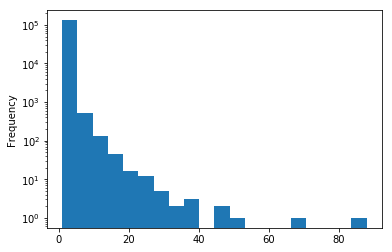

In [687]:
c_df = pd.DataFrame(conn_comp)
c_df.columns = ['comp_id']
c_df.groupby(by='comp_id')['comp_id'].count().plot.hist(bins=20, log=True)

In [1087]:
g = g.drop_singletons()
len(g.records)

187

# Food for thought (and material for future experiments)
### Fan-in/Fan-out analysis
A good indicator of a product success might be represented by its *fan-in* metric, that is, the number of incoming edges. If a product has many incoming edges, it means that people decide to buy it after comparing it with several other products.
Conversely, if a product has a large number of outgoing edges (*fan-out*), it might be an indicator that it is not a good product (or is too pricey). Probably, it would also make sense to compare the *fan-in* minus *fan-out* metric, but *not* the ratio.

In [1088]:
df = pd.DataFrame()
df['fan_in'] = g.get_fan_in()
df['fan_out'] = g.get_fan_out()
df.index = pd.DataFrame(g.records)['asin']
df.sort_values('fan_in', ascending=False).head()

,fan_in,fan_out
asin,,
B00007E7C8,55,2
B004PNZFZ8,37,1
B000AJIF4E,15,2
B00HVLUR86,14,2
B0002Z82XA,12,4


Product **B00007E7C8** appears to be a pretty good product, as people buy it after coming from 58 other products.

,fan_in,fan_out
count,120787.000000,120787.000000
mean,2.476781,2.476781
std,13.967617,1.068280
min,0.000000,0.000000
25%,0.000000,2.000000
50%,0.000000,3.000000
75%,2.000000,3.000000
max,2484.000000,4.000000


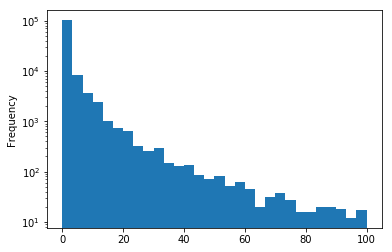

In [850]:
display(df.describe())
df['fan_in'].plot.hist(bins=30,log=True, range=(0, 100))

### Clique analysis
This is one of the most important aspects of our project. A max-clique is a set of totally interconnected nodes, which, in our scenario, represent products that are in direct competition among each other (and it is not really clear which "wins"). Note that these competition relations might even comprehend products of the same brand: this could turn out to be an interesting tools for vendors.

Our algorithm for finding max-cliques is optimized for dealing with sparse graphs, and works as follows (by induction):
- A single node is always a valid 1-clique
- The current clique is incrementally expanded using a DFS, making sure that the max-clique condition is always satisfied. This is achieved by ensuring that the last inserted node is connected to all previous nodes, and vice versa.
- If the current clique is not a sub-clique of a larger clique, it is marked as a max-clique.

In [252]:
%timeit g.extract_max_cliques()

277 µs ± 2.08 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


As can be seen, the performance is very good if we keep the dataset size small by splitting categories.

In [1089]:
cliques = g.extract_max_cliques()
#cliques = g.extract_connected_components(directed=True)
print(len(cliques), 'max-cliques found')

191 max-cliques found


We show some cliques of size 3:

In [1022]:
for c in cliques:
    if len(c) < 5:
        continue
    for i in c:
        print('*',g.records[i]['asin'],g.records[i]['title'], ' - $', g.records[i]['price'])#, records[i]['salesRank'][1])
    print('------')

In [852]:
r_df = pd.DataFrame(g.records)
#r_df['salesRankCat'] = r_df['salesRank'].map(lambda x: next(iter(x.keys())))
#r_df['salesRankPos'] = r_df['salesRank'].map(lambda x: next(iter(x.values())))
#r_df['fan_in'] = g.get_fan_in()
#r_df['fan_out'] = g.get_fan_out()

In [853]:
r_df.head()

,asin,average_rating,brand,category,component_size,description,fan_in,fan_out,helpful_fraction,imUrl,num_reviews,price,related,salesRankCat,salesRankPos,title
0,B00004SC3Y,4.265306,NaN,"[Electronics, Camera & Photo, Film Photography...",1,The Canon Elph 2 is one of the world's smalles...,1,1,0.832685,http://ecx.images-amazon.com/images/I/51435MC5...,49,12.99,"{'also_viewed': ['B00004TWM2', 'B000063YAN', '...",Camera &amp; Photo,9129,Canon Elph 2 APS Camera Kit
1,B000068O3D,4.283333,Hosa,"[Musical Instruments, Live Sound & Stage, Stag...",2,,8,2,0.613861,http://ecx.images-amazon.com/images/I/31wX2cMj...,120,5.53,"{'also_bought': ['B000KGYAYQ', 'B005HGM1D6', '...",Musical Instruments,749,HOSA CMP-110 Mono Interconnect - 3.5mm TRS to ...
2,B000068O3V,4.454545,Hosa,"[Electronics, Accessories & Supplies, Audio & ...",1,,0,1,0.000000,http://ecx.images-amazon.com/images/I/411XJCFF...,11,1.97,"{'also_bought': ['B000068O3S', 'B000068O5B', '...",Musical Instruments,1913,Hosa Cable GPR104 1/4 Inch Female TS To RCA Ma...
3,B00006HMGI,4.583333,General Electric,"[Electronics, Computers & Accessories, Network...",1,This GE USB 2.0 hub with 4 ports supports Wind...,0,3,0.340000,http://ecx.images-amazon.com/images/I/410Tr85Y...,12,5.00,"{'also_viewed': ['B00BWF5U0M', 'B003M0NURK', '...",Electronics,67449,GE HO97878 4-PORT USB 2.0 Hub
4,B00006WLCD,4.666667,NaN,"[Musical Instruments, Keyboards, Electronic Ke...",1,The PSR-290 has a special Portable Grand Piano...,0,3,0.872340,http://ecx.images-amazon.com/images/I/41PWJ9CF...,6,22.78,"{'also_viewed': ['B000YID5OG', 'B009115NQA', '...",Musical Instruments,82598,Yamaha PSR-290


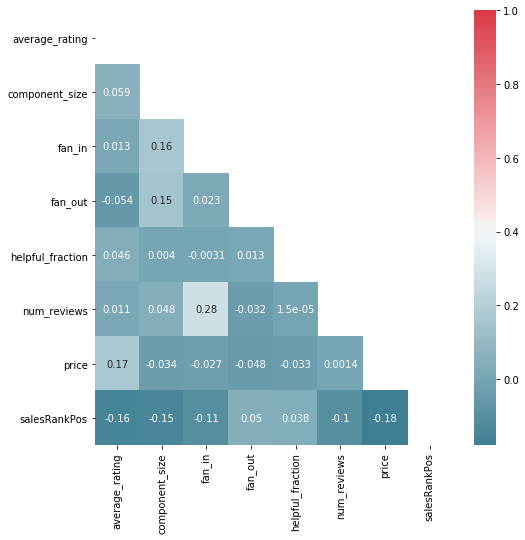

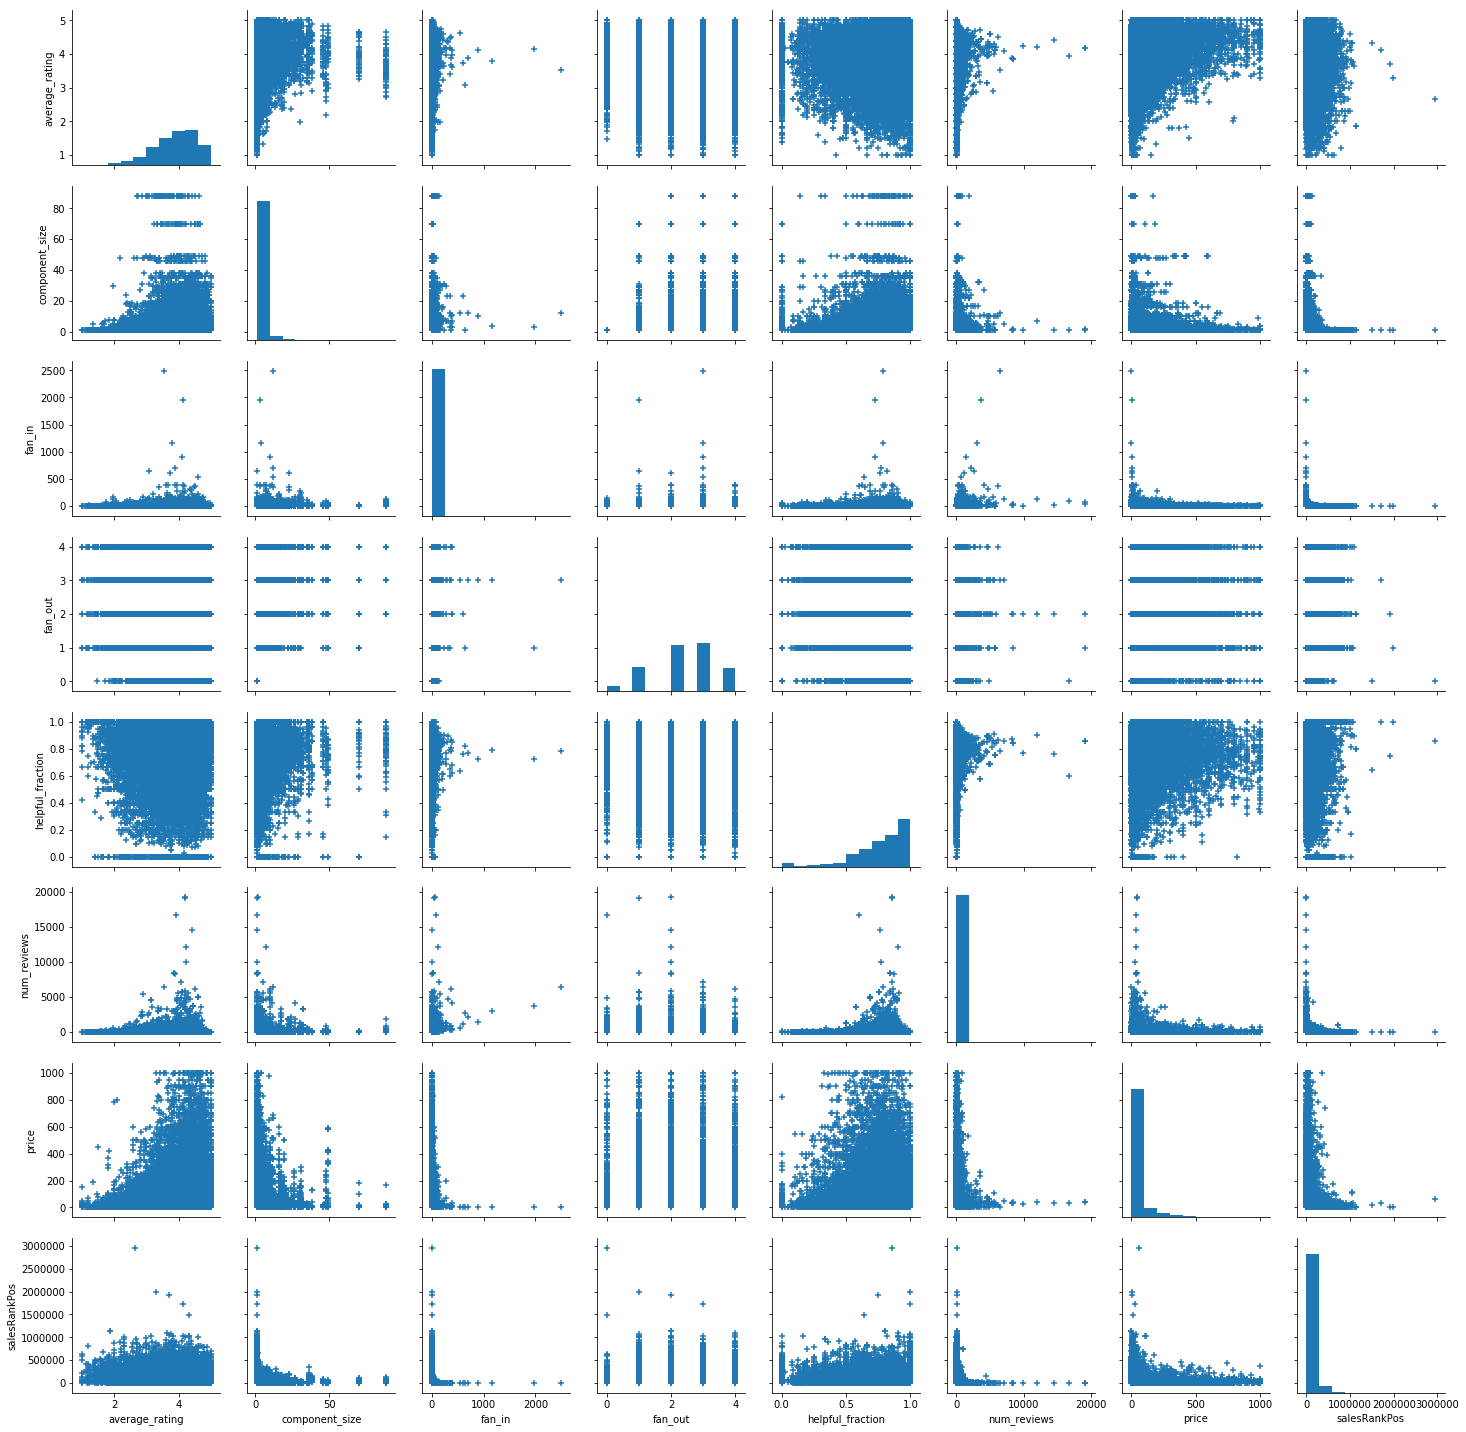

In [858]:
df_corr = r_df[r_df['num_reviews'] >= 5].dropna() # We select only product with more than 5 reviews


corr = df_corr.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.figure(figsize=(8, 8))
_ = sns.heatmap(corr, annot=True, mask=mask, cmap=cmap,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

sns.pairplot(df_corr, markers='+')

In [797]:
def majority(values):
    if len(values) < 2:
        return None
    
    count = 0
    for v in values:
        if count == 0:
            candidate = v
        if v == candidate:
            count += 1
        else:
            count -= 1
    frequency = 0
    for v in values:
        if v == candidate:
            frequency += 1
    if frequency > len(values)//2:
        return candidate
    else:
        return None

In [807]:
# Category verification
cnt1 = 0
cnt2 = 0
cl_notsame = []
for c in cliques:
    if len(c) > 10:
        cnt1 += 1
        cat = r_df['category'].loc[c[0]]
        same = True
        for elem in c:
            if r_df['category'].loc[elem] != cat:
                same = False
                cl_notsame.append(c)
                break
        cnt2 += same
print(cnt2/cnt1, 'of', cnt1)

0.2422360248447205 of 161


In [819]:
cnt1 = 0
cnt2 = 0
cl_notsame = []
cl_same = []
for c in cliques:
    if len(c) > 1:
        cats = r_df['category'].loc[c].values
        maj = majority(cats)
        cnt1 += 1
        if maj is not None:
            cnt2 += 1
            cl_same.append(c)
        else:
            cl_notsame.append(c)
print(cnt2/cnt1, 'of', cnt1)

0.8224368499257058 of 6730


In [826]:
wrong_prods = []
correct_prods = []
for c in cl_same:
    cats = r_df['category'].loc[c].values
    maj = majority(cats)
    for prod in c:
        if r_df['category'].loc[prod] == maj:
            correct_prods.append(prod)
        else:
            wrong_prods.append(prod)
print(len(correct_prods))
print(len(wrong_prods))

17057
1444


In [827]:
r_df.loc[correct_prods].describe()

,average_rating,fan_in,fan_out,helpful_fraction,num_reviews,price,salesRankPos
count,17057.000000,17057.000000,17057.000000,15944.000000,17057.000000,17057.000000,17057.000000
mean,4.024476,8.482558,2.686756,0.783616,78.419124,41.598333,52245.859295
std,0.573679,32.013324,0.916397,0.206336,282.496390,89.193839,72159.684200
min,1.333333,1.000000,1.000000,0.000000,5.000000,0.010000,5.000000
25%,3.666667,2.000000,2.000000,0.691785,10.000000,4.980000,5948.000000
50%,4.100000,4.000000,3.000000,0.818182,21.000000,11.720000,20108.000000
75%,4.450000,8.000000,3.000000,0.939485,53.000000,29.990000,68766.000000
max,5.000000,2484.000000,4.000000,1.000000,10110.000000,999.990000,656933.000000


In [828]:
r_df.loc[wrong_prods].describe()

,average_rating,fan_in,fan_out,helpful_fraction,num_reviews,price,salesRankPos
count,1444.000000,1444.000000,1444.000000,1351.000000,1444.000000,1444.000000,1444.000000
mean,4.064812,14.056787,2.764543,0.783864,97.845568,38.299072,43612.200139
std,0.543092,33.450197,0.888810,0.204016,310.592210,81.154539,64554.609514
min,1.800000,1.000000,1.000000,0.000000,5.000000,0.010000,3.000000
25%,3.714286,3.000000,2.000000,0.700254,12.000000,4.650000,3717.250000
50%,4.125000,6.000000,3.000000,0.815385,25.000000,9.950000,13668.000000
75%,4.471362,13.000000,3.000000,0.934058,65.000000,29.990000,52039.500000
max,5.000000,600.000000,4.000000,1.000000,4716.000000,979.990000,388357.000000


In [811]:
for c in cl_notsame[:10]:
    if len(c) < 2:
        continue
    for i in c:
        print('*',g.records[i]['asin'],g.records[i]['title'], ' - $', g.records[i]['category'])#, records[i]['salesRank'][1])
    print('------')

* B004XLATPI WUHAN WUSP 10-Inch Splash  Cymbal  - $ ['Musical Instruments', 'Drums & Percussion', 'Drum Sets & Set Components', 'Cymbals', 'Splash']
* B001FB63I6 Meinl Cymbals HCS18CR 18&quot; HCS Traditional Crash/Ride Cymbal  - $ ['Musical Instruments', 'Drums & Percussion', 'Drum Sets & Set Components', 'Cymbals', 'Crash-Ride']
* B0002F4MKM Wuhan WU10414 14-Inch Lion China Cymbal  - $ ['Musical Instruments', 'Drums & Percussion', 'Drum Sets & Set Components', 'Cymbals', 'China & Effect']
* B003H91GPY WUHAN WUCR16 Crash 16-Inch Gong  - $ ['Musical Instruments', 'Drums & Percussion', 'Drum Sets & Set Components', 'Cymbals', 'Crash']
* B0011380UC Meinl Cymbals HCS141620 Matched Cymbal Set:  14&quot; Hi Hat, 16&quot; Crash, 20&quot; Ride  - $ ['Musical Instruments', 'Drums & Percussion', 'Drum Sets & Set Components', 'Cymbals', 'Variety Packs']
* B006X0RGV2 Cannon UP1220DCS Double Braced Cymbal Stand  - $ ['Musical Instruments', 'Instrument Accessories', 'Drum & Percussion Accessories',

In [727]:
cnt1 = 0
cnt2 = 0
for c in cliques:
    if len(c) == 4:
        cnt1 += 1
        cnt2 += r_df['salesRankPos'].loc[c].argmin() == r_df['price'].loc[c].argmin()
print(cnt2/cnt1, 'of', cnt1)

0.379310344828 of 87


In [758]:
asin = 'B0052MRFYU'
sc.textFile('data/metadata.json')\
    .filter(lambda x: asin in x)\
    .map(lambda x: ast.literal_eval(x))\
    .filter(lambda x: x['asin'] == asin)\
    .take(1)

[{'asin': 'B0052MRFYU',
  'brand': 'Samsung',
  'categories': [['Cell Phones & Accessories', 'Cases', 'Basic Cases']],
  'description': 'Samsung Standard Battery, Samsung SCH-I510',
  'imUrl': 'http://ecx.images-amazon.com/images/I/412VwGzmVaL._SY300_.jpg',
  'price': 9.38,
  'related': {'also_bought': ['B005YTA5DY',
    'B0051HAYQ2',
    'B0053OEM0M',
    'B0052486M8',
    'B004YLZC9K',
    'B00HWIMOP2',
    'B004YLZC5Y',
    'B005HGFU6Q',
    'B0052486GY',
    'B0053E2HAO',
    'B0054ENBBM',
    'B00A7CGR1C',
    'B008KGIHB0',
    'B0050D85BS',
    'B004VXZN7W',
    'B005C66O2A',
    'B0053RQ9QE',
    'B0051PH9LC',
    'B005WEZGSK',
    'B00A7CKBLE',
    'B006PGUR9M',
    'B004YLZDLW',
    'B004XR91VU',
    'B00C2ZETDA',
    'B007J5T3AC',
    'B0050JJI2M',
    'B004CP84U2',
    'B004WOBMGG',
    'B006YCU5MQ',
    'B0096SNGNU',
    'B009SQSV7G',
    'B00C8ZUXBG',
    'B005M5N7JE',
    'B003ZND39Y',
    'B00DP0QJPM',
    'B005AYJCZU',
    'B005KF8YPI',
    'B005TAY4T4',
    'B008L3IDDO

In [762]:
count = 0
count_tot = 0
cols = ['average_rating', 'price', 'salesRankPos', 'fan_in', 'num_reviews']
data = []
for c in cliques:
    if len(c) > 2:
        df_tmp = r_df[cols].loc[c].rank()
        data.append(df_tmp)
res = pd.concat(data)
res.head()

,average_rating,price,salesRankPos,fan_in,num_reviews
17,1.0,1.0,2.0,2.0,1.0
6102,3.0,2.0,1.0,1.0,3.0
131292,2.0,3.0,3.0,3.0,2.0
51,1.0,3.0,2.0,3.0,2.0
106811,2.0,1.5,1.0,1.5,3.0


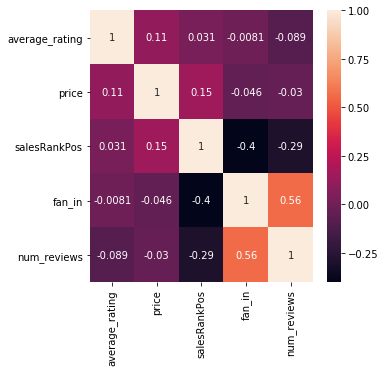

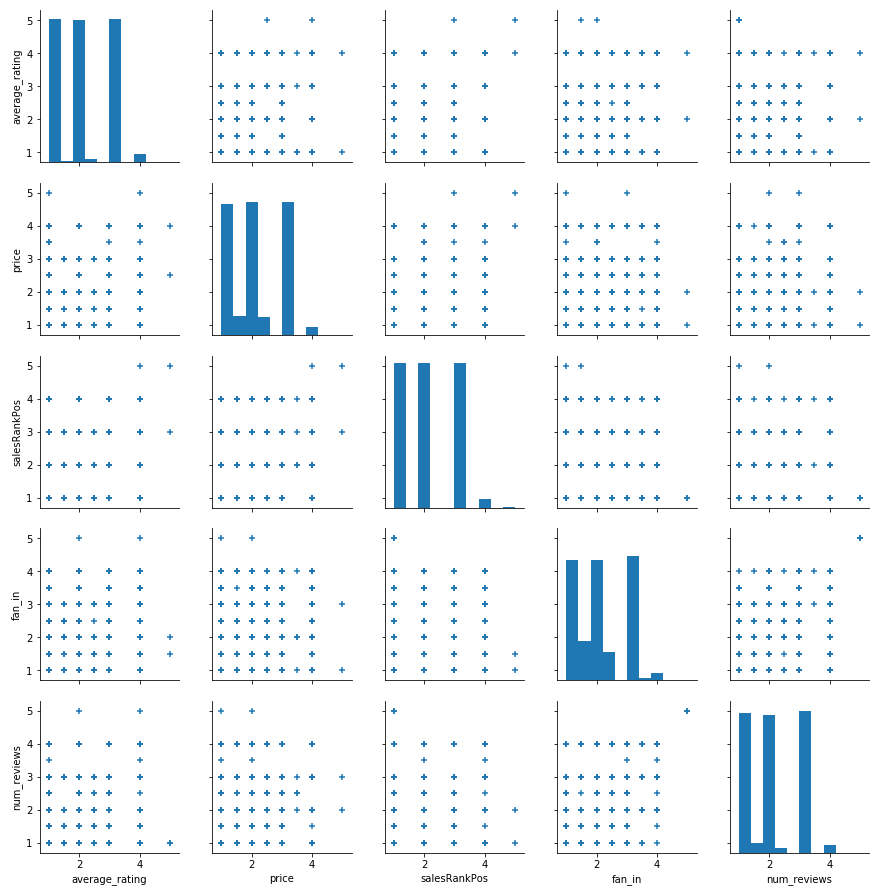

In [763]:
corr = res.corr()
plt.figure(figsize=(5,5))
_ = sns.heatmap(corr, annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

sns.pairplot(res, markers='+')

The result is indeed interesting. We can observe competing products of different brands, a well as competing products of the same brand. In some cases, the cliques represent the same product in different colors.

The important observation, here, is that these products present similar characteristics. For example, one of the groups shows competing *wireless headphones*, whereas another one shows binaural headphones.

Of course, we carried out this analysis on other categories as well (e.g. mobile phones), with similar results.

## Conclusion and future work

We can safely conclude that our project is feasible. The data seems to reflect our assumptions, and our pipeline allows us to process it in reasonable time.

Quoting the README, as a guideline until Milestone 3, we aim to accomplish the following goals:
- Investigate the cliques to gain useful insights, as defined in Milestone 1. In particular, we want to extract recurrent patterns from the graph.
- Obtain the best metric for evaluating a product, among average rating, sales rank, ingoing edges, or other potential metrics that we might discover in the future.
- Now that we have the pipeline in place, we could try to answer the open questions in the initial proposal.

From a technical perspective, the clique extraction algorithm will be automated so as to be performed on all categories (with a Spark job), and not just a sample category as we showed here (the category tree will assist us in this task). Finally, all cliques will be grouped and analyzed with the aim of finding correlations between the elements in them. For instance, a simple question might be: is the most sold product in a group also the cheapest? Or, more generally, can we predict the most preferred product in a group according to some features?

In [172]:
# TODO: build dataframe with fan-in, fan-out, etc...

In [564]:
cliques = g.extract_max_cliques()
#conn_comp = g.get_connected_components(directed=False)

In [565]:
# Node map (node to list of clique IDs (a node can be in multiple cliques))
node_map = []
merged_node_map = []
for i in range(len(g.adj_list)):
    node_map.append([])
    merged_node_map.append([])
    
for idx, clique in enumerate(cliques):
    for node in clique:
        node_map[node].append(idx)
        
for i, node_cliques in enumerate(node_map):
    if len(node_cliques) > 1:
        target = node_cliques[0]
        # Merge
        for clique_idx in node_cliques:
            for node_idx in cliques[clique_idx]:
                merged_node_map[node_idx] = [target]
    else:
        merged_node_map[i] = node_cliques

In [569]:
for i, c in enumerate(cliques):
    print(i, c)

0 [0]
1 [1, 1083]
2 [2]
3 [3]
4 [4]
5 [5]
6 [6, 4091]
7 [7]
8 [8]
9 [9]
10 [10]
11 [11]
12 [12]
13 [13]
14 [14]
15 [15]
16 [16]
17 [17]
18 [18, 441]
19 [19]
20 [20]
21 [21, 302]
22 [22]
23 [23]
24 [24]
25 [25]
26 [26]
27 [27]
28 [28, 2646]
29 [29]
30 [30]
31 [31]
32 [32]
33 [33]
34 [34]
35 [35]
36 [36]
37 [37]
38 [38]
39 [39]
40 [40]
41 [41]
42 [42]
43 [43]
44 [44]
45 [45]
46 [46]
47 [47]
48 [48]
49 [49]
50 [50, 3742]
51 [51]
52 [52]
53 [53]
54 [54]
55 [55]
56 [56]
57 [57]
58 [58, 1997]
59 [59]
60 [60, 740]
61 [61]
62 [62]
63 [63]
64 [64]
65 [65]
66 [66]
67 [67]
68 [68]
69 [69]
70 [70]
71 [71]
72 [72, 772]
73 [72, 4119, 4936]
74 [72, 4936]
75 [73]
76 [74, 5095]
77 [75]
78 [76, 2994]
79 [77]
80 [78]
81 [79, 427]
82 [80]
83 [81, 1779]
84 [82]
85 [83]
86 [84]
87 [85]
88 [86, 1066, 1588]
89 [86, 1588]
90 [86, 4373]
91 [87, 4035, 4988]
92 [87, 4988]
93 [88]
94 [89, 3635]
95 [90]
96 [91]
97 [92]
98 [93]
99 [94]
100 [95]
101 [96, 1005]
102 [97, 1439, 2654]
103 [97, 2654]
104 [98]
105 [99]
106

996 [945, 1594]
997 [945, 2592]
998 [945, 5077]
999 [946, 3315]
1000 [947]
1001 [948]
1002 [949]
1003 [950]
1004 [951]
1005 [952]
1006 [953]
1007 [954]
1008 [955]
1009 [956]
1010 [957, 2730]
1011 [958, 3327]
1012 [959]
1013 [960]
1014 [961]
1015 [962]
1016 [963]
1017 [964]
1018 [965]
1019 [966]
1020 [967]
1021 [968]
1022 [969, 2893]
1023 [969, 3077]
1024 [970]
1025 [971]
1026 [972]
1027 [973]
1028 [974]
1029 [975]
1030 [976, 1295]
1031 [977]
1032 [978]
1033 [979]
1034 [980]
1035 [981]
1036 [982]
1037 [983]
1038 [984, 1550]
1039 [985]
1040 [986]
1041 [987]
1042 [988]
1043 [989, 3524]
1044 [990]
1045 [991]
1046 [992, 3793]
1047 [993]
1048 [994]
1049 [995]
1050 [996]
1051 [997]
1052 [998]
1053 [999, 1688]
1054 [1000]
1055 [1001]
1056 [1002]
1057 [1003]
1058 [1004]
1059 [1005, 1719]
1060 [1006]
1061 [1007]
1062 [1008]
1063 [1009, 4532]
1064 [1009, 4802]
1065 [1010]
1066 [1011]
1067 [1012, 3472]
1068 [1013]
1069 [1014]
1070 [1015]
1071 [1016]
1072 [1017]
1073 [1018, 4506]
1074 [1019]
1075 [

2311 [2191]
2312 [2192]
2313 [2193]
2314 [2194]
2315 [2195, 2548]
2316 [2196]
2317 [2197]
2318 [2198]
2319 [2199]
2320 [2200]
2321 [2201]
2322 [2202]
2323 [2203]
2324 [2204]
2325 [2205]
2326 [2206]
2327 [2207]
2328 [2208]
2329 [2209]
2330 [2210]
2331 [2211]
2332 [2212]
2333 [2213]
2334 [2214]
2335 [2215]
2336 [2216]
2337 [2217]
2338 [2218]
2339 [2219]
2340 [2220]
2341 [2221]
2342 [2222]
2343 [2223]
2344 [2224]
2345 [2225]
2346 [2226]
2347 [2227]
2348 [2228]
2349 [2229]
2350 [2230]
2351 [2231]
2352 [2232, 4939]
2353 [2233]
2354 [2234]
2355 [2235]
2356 [2236]
2357 [2237]
2358 [2238]
2359 [2239]
2360 [2240]
2361 [2241, 5302]
2362 [2242]
2363 [2243]
2364 [2244]
2365 [2245]
2366 [2246]
2367 [2247, 2673]
2368 [2248]
2369 [2249]
2370 [2250]
2371 [2251]
2372 [2252]
2373 [2253]
2374 [2254]
2375 [2255]
2376 [2256]
2377 [2257]
2378 [2258]
2379 [2259]
2380 [2260]
2381 [2261]
2382 [2262]
2383 [2263]
2384 [2264]
2385 [2265]
2386 [2266]
2387 [2267]
2388 [2268]
2389 [2269]
2390 [2270, 2454]
2391 [2271

3746 [3591]
3747 [3592]
3748 [3593, 4657]
3749 [3594]
3750 [3595, 4938]
3751 [3596]
3752 [3597]
3753 [3598]
3754 [3599]
3755 [3600]
3756 [3601]
3757 [3602]
3758 [3603]
3759 [3604]
3760 [3605]
3761 [3606]
3762 [3607]
3763 [3608]
3764 [3609]
3765 [3610]
3766 [3611]
3767 [3612]
3768 [3613]
3769 [3614, 5277]
3770 [3615]
3771 [3616]
3772 [3617]
3773 [3618]
3774 [3619, 4580]
3775 [3620, 4279]
3776 [3621, 4051]
3777 [3622]
3778 [3623]
3779 [3624]
3780 [3625]
3781 [3626]
3782 [3627]
3783 [3628]
3784 [3629]
3785 [3630]
3786 [3631]
3787 [3632]
3788 [3633, 4440]
3789 [3634]
3790 [3635]
3791 [3636]
3792 [3637]
3793 [3638]
3794 [3639]
3795 [3640]
3796 [3641]
3797 [3642, 3743]
3798 [3642, 5256]
3799 [3643]
3800 [3644]
3801 [3645]
3802 [3646]
3803 [3647]
3804 [3648, 4883]
3805 [3649]
3806 [3650]
3807 [3651]
3808 [3652]
3809 [3653]
3810 [3654]
3811 [3655]
3812 [3656]
3813 [3657]
3814 [3658]
3815 [3659]
3816 [3660, 5205]
3817 [3661]
3818 [3662]
3819 [3663]
3820 [3664]
3821 [3665]
3822 [3666]
3823 [3667

5093 [4927]
5094 [4928]
5095 [4929]
5096 [4930]
5097 [4931]
5098 [4932]
5099 [4933]
5100 [4934]
5101 [4935]
5102 [4936]
5103 [4937]
5104 [4938]
5105 [4939]
5106 [4940]
5107 [4941]
5108 [4942]
5109 [4943]
5110 [4944]
5111 [4945]
5112 [4946, 5164]
5113 [4947]
5114 [4948]
5115 [4949]
5116 [4950]
5117 [4951]
5118 [4952]
5119 [4953]
5120 [4954]
5121 [4955]
5122 [4956]
5123 [4957]
5124 [4958]
5125 [4959, 5125]
5126 [4960]
5127 [4961]
5128 [4962]
5129 [4963]
5130 [4964]
5131 [4965]
5132 [4966]
5133 [4967, 5019, 5225]
5134 [4967, 5225]
5135 [4968]
5136 [4969]
5137 [4970]
5138 [4971]
5139 [4972]
5140 [4973]
5141 [4974]
5142 [4975]
5143 [4976]
5144 [4977]
5145 [4978]
5146 [4979]
5147 [4980]
5148 [4981]
5149 [4982]
5150 [4983]
5151 [4984]
5152 [4985]
5153 [4986]
5154 [4987]
5155 [4988]
5156 [4989]
5157 [4990]
5158 [4991]
5159 [4992]
5160 [4993]
5161 [4994]
5162 [4995]
5163 [4996]
5164 [4997]
5165 [4998]
5166 [4999]
5167 [5000]
5168 [5001]
5169 [5002]
5170 [5003]
5171 [5004]
5172 [5005]
5173 [5006

In [571]:
cnt = 0
cnt_1 = 0
for i, idx in enumerate(node_map):
    if len(idx) > 1:
        print(i, idx)
        cnt += 1
    else:
        cnt_1 += 1
print(cnt, cnt_1)

72 [72, 73, 74]
86 [88, 89, 90]
87 [91, 92]
97 [102, 103]
102 [108, 109]
111 [118, 119, 120]
136 [145, 146]
137 [147, 148]
144 [155, 156]
178 [190, 191]
195 [208, 209]
202 [126, 216]
204 [218, 219]
219 [234, 235]
228 [190, 244, 245, 246]
288 [306, 307]
302 [21, 321]
330 [349, 350]
335 [355, 356, 357]
351 [373, 374]
366 [389, 390]
379 [403, 404]
386 [411, 412, 413]
402 [429, 430]
410 [438, 439]
417 [446, 447]
420 [450, 451, 452]
427 [81, 459]
441 [18, 473]
482 [514, 515]
485 [518, 519]
496 [530, 531]
506 [541, 542]
546 [582, 583]
552 [589, 590]
554 [592, 593, 594]
564 [306, 604]
603 [446, 643]
626 [334, 666]
649 [477, 689]
665 [705, 706]
694 [735, 736]
740 [60, 782]
751 [793, 794]
753 [796, 797]
772 [72, 816]
777 [418, 821]
803 [847, 848]
817 [862, 863]
840 [886, 887]
852 [217, 899]
860 [250, 907, 908]
862 [910, 911, 912]
926 [976, 977]
931 [152, 982]
945 [996, 997, 998]
946 [380, 999]
958 [234, 1011]
966 [321, 1019]
969 [1022, 1023]
1005 [101, 1059]
1009 [1063, 1064]
1018 [411, 1073]
1

In [1092]:
g.records[0]

{'asin': 'B00AEVCRME',
 'average_rating': 4.222222222222222,
 'brand': 'CAD Audio',
 'category': ['Electronics',
  'Accessories & Supplies',
  'Audio & Video Accessories',
  'Headphones'],
 'component_size': 1,
 'description': '',
 'fan_in': 0,
 'fan_out': 1,
 'helpful_fraction': 0.6802325581395349,
 'imUrl': 'http://ecx.images-amazon.com/images/I/41QnkThFQXL._SY300_.jpg',
 'num_reviews': 36,
 'price': 60.13,
 'related': {'also_bought': ['B0083J7FMG',
   'B000068O54',
   'B0051M6J48',
   'B00BWF5U0M',
   'B000KIPT30',
   'B004VM5R7Y',
   'B0082918X4',
   'B0007NQH98',
   'B000068O17'],
  'bought_together': ['B00BWF5U0M'],
  'buy_after_viewing': ['B00G5G7EXY',
   'B008JFUS5A',
   'B00007E7C8',
   'B0001ARCFA',
   'B0001ARCFA']},
 'salesRankCat': 'Musical Instruments',
 'salesRankPos': 38611,
 'title': 'The Sessions Professional Closed-Back Studio Headphones by CAD Audio - White with Red'}

In [1093]:
nodes = []
for i, node in enumerate(merged_node_map):
    r = g.records[i]
    nodes.append({
        'asin': r['asin'],
        'name': r['title'],
        'imUrl': r['imUrl'],
        'price': r['price'],
        'numReviews': r['num_reviews'],
        'group': node[0],
        'fanIn': r['fan_in'],
        'fanOut': r['fan_out'],
        'compSize': r['component_size']
        #'component': int(conn_comp[i]),
        #'hashColor': '#' + hashlib.sha256(str(conn_comp[i]).encode()).hexdigest()[:6]
    })
    if 'average_rating' in r:
        nodes[-1]['averageRating'] = r['average_rating']
    if 'helpfulFraction' in r:
        nodes[-1]['helpfulFraction'] = r['helpfulFraction']
    if 'brand' in r:
        nodes[-1]['brand'] = r['brand']
    if 'salesRankCat' in r:
        nodes[-1]['salesRankCategory'] = r['salesRankCat']
        nodes[-1]['salesRank'] = r['salesRankPos']
    
links = []
for i, adj in enumerate(g.adj_list):
    inv = g.adj_list_incoming[i]
    all_adj = set(adj + inv)
    # Undirected?
    for j in all_adj:
        if i >= j:
            continue
        links.append({
            'source': i,
            'target': j,
            'right': j in adj,
            'left': j in inv,
            'value': 1
        })
        
graph = {'nodes': nodes, 'links': links}
with open('graph.json', 'w') as outfile:
    json.dump(graph, outfile)

In [ ]:
# Build the category tree
category_tree = sc.textFile('data/reduced.json')\
    .map(lambda x: json.loads(x))\
    .filter(lambda x: x[0] in categories_to_extract)\
    .map(convert_to_tree)\
    .reduce(merge_trees)

# Category analysis

In [1094]:
# TODO: test if bought_together is symmetric
products = sc.textFile('data/reduced.json')\
    .map(json.loads)\
    .filter(lambda x: len(x['category']) >= 3)
    
product_categories = products.map(lambda x: (x['asin'], x['category']))\
    .mapValues(lambda x: tuple(x[:3]))

co_occurrences = products.filter(lambda x: 'related' in x and 'bought_together' in x['related'])\
    .map(lambda x: (x['asin'], x['related']['bought_together']))\
    .join(product_categories)\
    .map(lambda x: (x[1][1], x[1][0]))\
    .flatMapValues(lambda x: x)\
    .map(lambda x: (x[1], x[0]))\
    .join(product_categories)\
    .filter(lambda x: x[1][0] != x[1][1])\
    .map(lambda x: (tuple(sorted((x[1][0], x[1][1]))), 1))\
    .reduceByKey(lambda x, y: x + y)\
    .collect()
    
#for sorted tuples .map(lambda x: (tuple(sorted((x[1][0], x[1][1]))), 1))\
#for unsorted tuples .map(lambda x: ((x[1][0], x[1][1]), 1))\

In [1095]:
vals = []
for c in co_occurrences:
    vals.append(c[1])
    if c[1] > 10:
        print(c)

((('Cell Phones & Accessories', 'Accessories', 'Screen Protectors'), ('Cell Phones & Accessories', 'Accessories', 'Stylus Pens')), 110)
((('Automotive', 'Exterior Accessories', 'Towing Products & Winches'), ('Automotive', 'Exterior Accessories', 'Truck Bed & Tailgate Accessories')), 49)
((('Electronics', 'Accessories & Supplies', 'Batteries, Chargers & Accessories'), ('Electronics', 'Computers & Accessories', 'Computer Components')), 161)
((('Musical Instruments', 'Instrument Accessories', 'General Accessories'), ('Musical Instruments', 'Instrument Accessories', 'Guitar & Bass Accessories')), 287)
((('Automotive', 'Tools & Equipment', 'Tool Sets'), ('Tools & Home Improvement', 'Power & Hand Tools', 'Power Tool Accessories')), 14)
((('Cell Phones & Accessories', 'Accessories', 'Phone Charms'), ('Cell Phones & Accessories', 'Cases', 'Basic Cases')), 239)
((('Automotive', 'Replacement Parts', 'Ignition Parts'), ('Automotive', 'Replacement Parts', 'Switches & Relays')), 61)
((('Electronics

((('Cell Phones & Accessories', 'Accessories', 'Bluetooth Speakers'), ('Cell Phones & Accessories', 'Accessories', 'Chargers')), 23)
((('Tools & Home Improvement', 'Electrical', 'Light Bulbs'), ('Tools & Home Improvement', 'Lighting & Ceiling Fans', 'Novelty Lighting')), 78)
((('Automotive', 'Exterior Accessories', 'Grilles & Grille Guards'), ('Automotive', 'Tires & Wheels', 'Accessories')), 14)
((('Tools & Home Improvement', 'Electrical', 'Cords, Adapters & Multi-Outlets'), ('Tools & Home Improvement', 'Electrical', 'Light Sockets')), 23)
((('Cell Phones & Accessories', 'Accessories', 'Signal Boosters'), ('Electronics', 'Computers & Accessories', 'Cables & Accessories')), 19)
((('Automotive', 'Interior Accessories', 'Safety'), ('Automotive', 'Replacement Parts', 'Exhaust & Emissions')), 19)
((('Electronics', 'Camera & Photo', 'Video Surveillance'), ('Electronics', 'Security & Surveillance', 'Accessories')), 484)
((('Tools & Home Improvement', 'Painting Supplies & Wall Treatments', 'Pa

In [1119]:
out_json = {}
for c in co_occurrences:
    if c[1] > 100:
        key = '|'.join(c[0][0])
        value = '|'.join(c[0][1])
        #if key > value:
        #    value, key = key, value
        if key not in out_json:
            out_json[key] = [0, []]
        if value not in out_json:
            out_json[value] = [0, []]
        out_json[key][1].append(value)
        out_json[key][0] += c[1]
out_json = list(map(lambda x: {'name': x[0], 'size': x[1][0], 'imports': list(set(x[1][1]))}, out_json.items()))

In [1120]:
out_json

[{'imports': ['Cell Phones & Accessories|Cases|Wallet Cases',
   'Cell Phones & Accessories|Cases|Basic Cases',
   'Electronics|Computers & Accessories|Touch Screen Tablet Accessories',
   'Electronics|Computers & Accessories|Cables & Accessories',
   'Cell Phones & Accessories|Cell Phones|No-Contract Cell Phones',
   'Electronics|Portable Audio & Video|MP3 Players & Accessories',
   'Cell Phones & Accessories|Cases|Armbands',
   'Cell Phones & Accessories|Cell Phones|Unlocked Cell Phones',
   'Cell Phones & Accessories|Cases|Holsters & Clips',
   'Cell Phones & Accessories|Accessories|Stylus Pens'],
  'name': 'Cell Phones & Accessories|Accessories|Screen Protectors',
  'size': 43395},
 {'imports': ['Electronics|Computers & Accessories|Cables & Accessories',
   'Electronics|Computers & Accessories|Touch Screen Tablet Accessories',
   'Cell Phones & Accessories|Cases|Basic Cases'],
  'name': 'Cell Phones & Accessories|Accessories|Stylus Pens',
  'size': 618},
 {'imports': ['Musical Inst

In [1121]:
with open('relations.json', 'w') as outfile:
    json.dump(out_json, outfile)

(array([  7.35580000e+04,   1.50000000e+02,   4.60000000e+01,
          2.10000000e+01,   8.00000000e+00,   1.00000000e+01,
          4.00000000e+00,   2.00000000e+00,   2.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   3.00000000e+00,
          2.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   2.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]),
 array([    0.,   200.,   400.,   600.,   800.,  1000.,  1200.,  1400.,
         1600.,  1800.,  2000.,  2200.,  2400.,  2600.,  2800.,  3000.,
         3200.,  3400.,  3600.,  3800.,  4000.,  4200.,  4400.,  4600.,
         4800.,  5000.,  5200.,  5400.,  5600.,  5800.,  6000.]),
 <a list of 30 Patch objects>)

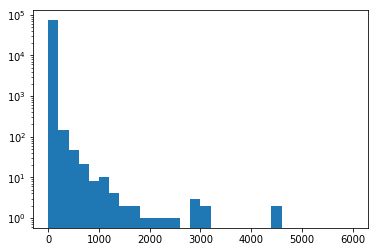

In [881]:
plt.hist(vals, log=True, bins=30, range=(0,6000))

In [862]:
records

483116

# Augmented category tree

In [923]:
category_tree = sc.textFile('data/reduced.json')\
    .map(json.loads)\
    .map(lambda x: x['category'])\
    .map(convert_to_tree)\
    .reduce(merge_trees)

In [925]:
category_tree

{'Automotive': (331049,
  {'Automotive Enthusiast Merchandise': (39,
    {'Apparel': (1, {}),
     'Home & Office': (3, {}),
     'Toys & Models': (4, {}),
     'Vehicle Accessories': (24, {})}),
   'Car Care': (6014,
    {'Cleaning Kits': (10, {}),
     'Exterior Care': (3702,
      {'Car Polishes & Waxes': (851,
        {'Chrome & Metal Polishes': (228,
          {'Chrome Polishes': (26, {}), 'Metal Polishes': (202, {})}),
         'Pre-Wax Cleaners': (73,
          {'Bug & Sap Removers': (51, {}), 'Tar & Wax Removers': (22, {})}),
         'Waxes': (519, {})}),
       'Car Wash Equipment': (390,
        {'Applicators': (41, {}),
         'Buckets': (65, {}),
         'Nozzles & Hose Attachments': (39, {}),
         'Sponges & Mitts': (143, {}),
         'Waterless Wash Treatments': (68, {}),
         'Windshield Squeegees': (33, {})}),
       'Cleaners': (2014, {}),
       'Convertible Top Cleaners': (17, {}),
       'Polishing & Rubbing Compounds': (50, {}),
       'Polishing & Wax

In [935]:
import copy

def merge_small_categories(node):
    if len(node) == 0:
        return
    
    for k, v in node.items():
        if k == 'Painting Supplies & Wall Treatments':
            print('xxxxxxxxxx')
        if v[0] < 1000:
            # Merge children
            node[k] = (v[0], {})
        else:
            prune_tree(v[1])
        if node[k][0] < 0:
            print('wtf')
            
def short_circuit_categories(node):
    if len(node) == 0:
        return
    
    for k, v in node.items():
        short_circuit_categories(v[1])
        if len(v[1]) == 1:
            node[k] = (v[0], next(iter(v[1].values()))[1])
            
def prune_small_categories(node):
    if len(node) == 0:
        return
    
    for k, v in node.items():
        pass
        
pruned = copy.deepcopy(category_tree)
while True:
    pruned_old = copy.deepcopy(pruned)
    merge_small_categories(pruned)
    #short_circuit_categories(pruned)
    print('iter')
    if pruned_old == pruned:
        break
pruned

iter
iter
iter
iter
iter
iter
iter
iter
iter


{'Automotive': (331049,
  {'Automotive Enthusiast Merchandise': (39, {}),
   'Car Care': (1986,
    {'Cleaning Kits': (10, {}),
     'Exterior Care': (-326, {}),
     'Finishing': (301, {}),
     'Glass Care': (2, {}),
     'Interior Care': (841, {}),
     'Tire & Wheel Care': (4, {}),
     'Tools & Equipment': (1046,
      {'Air Dryers, Blowers & Blades': (23, {}),
       'Brushes & Dusters': (248, {}),
       'Cloths & Towels': (607, {}),
       'Detailing Tools': (129, {}),
       'Machine Polishing Equipment': (39, {})})}),
   'Exterior Accessories': (18986,
    {'Antenna Toppers': (559, {}),
     'Body Armor': (197, {}),
     'Bumpers & Bumper Accessories': (658, {}),
     'Cargo Management': (1467,
      {'Brackets': (62, {}),
       'Cargo Bars': (196, {}),
       'Cargo Carriers': (375, {}),
       'Cargo Racks': (695, {}),
       'Ladders': (22, {}),
       'Rack Adapters': (51, {}),
       'Rack Fairings': (13, {}),
       'Rack Locks': (5, {}),
       'Ratcheting Cargo Bars'

In [920]:
category_tree['Electronics'][1]

{'Accessories & Supplies': (67322,
  {'Audio & Video Accessories': (48093,
    {'3D Glasses': (809, {}),
     'Antennas': (1052,
      {'Radio Antennas': (282, {}), 'TV Antennas': (712, {})}),
     'Cables & Interconnects': (13714,
      {'Audio Cables': (5080,
        {'Digital Coaxial Cables': (311, {}),
         'Fiber Optic Cables': (693, {}),
         'RCA Cables': (1322, {}),
         'Speaker Cables': (1249, {}),
         'Stereo Jack Cables': (981, {}),
         'Subwoofer Cables': (163, {})}),
       'Power Cables': (1475, {}),
       'Video Cables': (6839,
        {'Component Video': (240, {}),
         'Composite Video': (449, {}),
         'DVI Cables': (473, {}),
         'F-Pin-Coaxial Tip': (682, {}),
         'HDMI Cables': (4649, {}),
         'S-Video Cables': (239, {})})}),
     'Cleaning & Repair': (731,
      {'Disc Cleaners': (120, {}),
       'Disc Repair Kits': (115, {}),
       'Head Cleaners': (109, {}),
       'Lens Cleaners': (271, {})}),
     'Connectors & 

In [914]:
pruned

{'Automotive': (331049,
  {'Automotive Enthusiast Merchandise': (39, {}),
   'Car Care': (4000,
    {'Cleaning Kits': (10, {}),
     'Exterior Care': (1688,
      {'Car Polishes & Waxes': (851, {}),
       'Car Wash Equipment': (390, {}),
       'Cleaners': (2014, {}),
       'Convertible Top Cleaners': (17, {}),
       'Polishing & Rubbing Compounds': (50, {}),
       'Polishing & Waxing Kits': (178, {}),
       'Sealants': (171, {}),
       'Water Blades': (31, {})}),
     'Finishing': (301, {}),
     'Glass Care': (2, {}),
     'Interior Care': (841, {}),
     'Tire & Wheel Care': (4, {}),
     'Tools & Equipment': (1046,
      {'Air Dryers, Blowers & Blades': (23, {}),
       'Brushes & Dusters': (248, {}),
       'Cloths & Towels': (607, {}),
       'Detailing Tools': (129, {}),
       'Machine Polishing Equipment': (39, {})})}),
   'Exterior Accessories': (27453,
    {'Antenna Toppers': (559, {}),
     'Body Armor': (197, {}),
     'Bumpers & Bumper Accessories': (658, {}),
     

In [890]:
category_tree

{'Automotive': (331049,
  {'Automotive Enthusiast Merchandise': (39,
    {'Apparel': (1, {}),
     'Home & Office': (3, {}),
     'Toys & Models': (4, {}),
     'Vehicle Accessories': (24, {})}),
   'Car Care': (6014,
    {'Cleaning Kits': (10, {}),
     'Exterior Care': (3702,
      {'Car Polishes & Waxes': (851,
        {'Chrome & Metal Polishes': (228,
          {'Chrome Polishes': (26, {}), 'Metal Polishes': (202, {})}),
         'Pre-Wax Cleaners': (73,
          {'Bug & Sap Removers': (51, {}), 'Tar & Wax Removers': (22, {})}),
         'Waxes': (519, {})}),
       'Car Wash Equipment': (390,
        {'Applicators': (41, {}),
         'Buckets': (65, {}),
         'Nozzles & Hose Attachments': (39, {}),
         'Sponges & Mitts': (143, {}),
         'Waterless Wash Treatments': (68, {}),
         'Windshield Squeegees': (33, {})}),
       'Cleaners': (2014, {}),
       'Convertible Top Cleaners': (17, {}),
       'Polishing & Rubbing Compounds': (50, {}),
       'Polishing & Wax

# Text

In [1023]:
#cat = ['Electronics', 'Computers & Accessories', 'Laptops']
cat = ['Cell Phones & Accessories', 'Cell Phones']
#cat = ['Cell Phones & Accessories']
#cat = ['Electronics', 'Computers & Accessories', 'Computer Components']
#cat = ['Electronics', 'Camera & Photo', 'Digital Cameras']
#cat = ['Electronics', 'Accessories & Supplies', 'Audio & Video Accessories', 'Headphones']
#cat = ['Electronics']
records = sc.textFile('data/reduced.json')\
    .map(json.loads)\
    .filter(lambda x: 'title' in x and len(x['title']) > 0)\
    .filter(lambda x: x['category'][:len(cat)] == cat)\
    .collect()
len(records)

7086

In [1035]:
from graph import ProductGraph
import random
g = ProductGraph(records, add_edge_on='buy_after_viewing', remove_edge_on='bought_together')
g = g.drop_singletons()
cliques = g.extract_max_cliques()
len(cliques)

5474

In [1025]:
relations = []
for i, a in enumerate(g.records):
    for b_ in a['buy_after_viewing']:
        if b_ not in g.name_id_mapping:
            continue
        j = g.name_id_mapping[b_]
        b = g.records[j]
        if a['asin'] not in b['buy_after_viewing']:
            relations.append([i, j])

In [1026]:
cliques = relations
#cliques = conn_comps
len(cliques)

13885

In [697]:
# Try merge
node_set = {}
for i, clique in enumerate(cliques):
    merge_set = set()
    for node in clique:
        if node in node_set:
            # Merge
            merge_set.add(node_set[node])
        else:
            node_set[node] = i
            
    if len(merge_set) > 0:
        merge_set.add(i)
        min_clique = np.min(list(merge_set))
        new_clique = []
        for ms in merge_set:
            new_clique += cliques[ms]
            cliques[ms] = []
        
        for node in new_clique:
            node_set[node] = min_clique
        cliques[min_clique] = list(set(new_clique))
len(cliques)

4541

In [1036]:
node_set = set()
cliques_post = []
for clique in cliques:
    ok = True
    for node in clique:
        if node in node_set:
            ok = False
            break
    if ok:
        for node in clique:
            node_set.add(node)
        cliques_post.append(clique)
cliques = cliques_post
len(cliques)

4831

In [1037]:
cliques_pairs = []
for c in cliques:
    if len(c) >= 2:
        cliques_pairs.append(c)
random.seed(1)
random.shuffle(cliques_pairs)
cliques_pairs = np.array(cliques_pairs)
len(cliques_pairs)

388

In [1038]:
def train_model_rf(X_tr, y_tr, X_va, y_va, depth):
    clf = RandomForestClassifier(max_depth=depth, random_state=0, n_estimators=num_estimators, n_jobs=num_threads)
    #clf = LogisticRegression(penalty='l1', C=depth, fit_intercept=False)
    clf.fit(X_tr, y_tr)
    va_score = clf.score(X_va, y_va)
    return va_score, clf

def train_model_lr(X_tr, y_tr, X_va, y_va, lambda_):
    clf = LogisticRegression(penalty='l2', C=lambda_, fit_intercept=False)
    clf.fit(X_tr, y_tr)
    va_score = clf.score(X_va, y_va)
    return va_score, clf

In [1039]:
from scipy.sparse import hstack, vstack
from sklearn.model_selection import KFold, train_test_split

def get_features(clique_list):
    result = set()
    for c in clique_list:
        for elem in c:
            result.add(elem)
    
    return g.df['title'].loc[list(result)]

def build_data(clique_list):
    X = []
    y = []
    for clique in clique_list:
        if len(clique) >= 2:
            # We use permutations instead of combinations because we also want elements in reversed order
            for pair in itertools.permutations(clique, 2):
                pair = list(pair)
                a = g.df['fan_in'].loc[pair[0]] # Best
                b = g.df['fan_in'].loc[pair[1]] # Worst
                if a == b:
                    continue # Discard ties
                x_this = hstack([text_features[pair[0]], text_features[pair[1]]])
                y_this = 0 if a > b else 1
                X.append(x_this)
                y.append(y_this)
    return vstack(X), y

def build_data_(clique_list):
    X = []
    y = []
    fan_in_accord = 0
    fan_in_discord = 0
    for clique in clique_list:
        if len(clique) != 2:
            raise
        x_this = hstack([text_features[clique[0]], text_features[clique[1]]])
        y_this = 1
        X.append(x_this)
        y.append(y_this)
        
        if g.df['fan_in'].loc[clique[1]] >= g.df['fan_in'].loc[clique[0]]:
            fan_in_accord += 1
        else:
            fan_in_discord += 1
        
        x_this = hstack([text_features[clique[1]], text_features[clique[0]]])
        y_this = 0
        X.append(x_this)
        y.append(y_this)
    #print(fan_in_accord, fan_in_discord)
    return vstack(X), y

data_cv, data_test = train_test_split(cliques_pairs, test_size=0.2, random_state=0, shuffle=True)

k_fold = KFold(n_splits=5, shuffle=True, random_state=0)
depths = np.arange(5, 55, 5)
#depths = np.logspace(-2, 6, 10)
all_accuracies = []
try:
    for depth in depths:
        accuracies = []
        for train, validation in k_fold.split(data_cv):
            vectorizer = TfidfVectorizer(token_pattern='(?u)\\b\\w[a-zA-Z0-9_-]+\\b')
            vectorizer.fit(get_features(data_cv[train]))
            text_features = vectorizer.transform(g.df['title'])
            X_tr, y_tr = build_data(data_cv[train])
            X_va, y_va = build_data(data_cv[validation])
            #y_tr = np.random.randint(2, size=len(y_tr))
            #print('Training on', X_tr.shape, ', validating on', X_va.shape)
            va_score = train_model_rf(X_tr, y_tr, X_va, y_va, depth)[0]
            accuracies.append(va_score)
        print('Depth:', depth, '- Accuracy:', np.mean(accuracies), '- std:', np.std(accuracies))
        all_accuracies.append(np.mean(accuracies))
except KeyboardInterrupt:
    print('Interrupted.')

best_depth = depths[np.argmax(all_accuracies)]
print('Best depth:', best_depth)

Depth: 5 - Accuracy: 0.545221211892 - std: 0.0340317806459
Depth: 10 - Accuracy: 0.544172126569 - std: 0.0430467873075
Depth: 15 - Accuracy: 0.542257440691 - std: 0.0383369997851
Depth: 20 - Accuracy: 0.535336528006 - std: 0.0309129499917
Depth: 25 - Accuracy: 0.548491372896 - std: 0.0390659638727
Depth: 30 - Accuracy: 0.554671907944 - std: 0.0336082496532
Depth: 35 - Accuracy: 0.55122467212 - std: 0.0329745843981
Depth: 40 - Accuracy: 0.541667696837 - std: 0.0371399204717
Depth: 45 - Accuracy: 0.540250297032 - std: 0.0366494632733
Depth: 50 - Accuracy: 0.54954045822 - std: 0.0326468612953
Best depth: 30


In [1040]:
vectorizer = TfidfVectorizer(token_pattern='(?u)\\b\\w[a-zA-Z0-9_-]+\\b')
vectorizer.fit(get_features(data_cv))
text_features = vectorizer.transform(g.df['title'])
X, y = build_data(data_cv)
X_te, y_te = build_data(data_test)
score, clf = train_model_rf(X, y, X_te, y_te, best_depth)
print('Test accuracy:', score)

Test accuracy: 0.540229885057


In [1041]:
important_features = pd.DataFrame(clf.feature_importances_, columns=['importance'])
important_features['std'] = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

important_features = important_features.sort_values(by='importance', ascending=False).head(1000)

mapping = np.array(vectorizer.get_feature_names())
num_index = important_features.index
important_features.index = important_features.index.map(lambda x: mapping[x % len(mapping)] + "_" + str(x // len(mapping)))
important_features

,importance,std
black_1,0.020236,0.020314
black_0,0.018836,0.019745
white_0,0.015855,0.018036
white_1,0.015549,0.018622
unlocked_0,0.013622,0.013845
android_0,0.013361,0.016695
android_1,0.012753,0.015886
unlocked_1,0.012097,0.012436
phone_0,0.010711,0.012519
phone_1,0.010083,0.011586


In [997]:
important_features = pd.DataFrame(clf.feature_importances_, columns=['importance'])
important_features['std'] = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

important_features = important_features.sort_values(by='importance', ascending=False)
#best_features = important_features[important_features.index // len(mapping) == 0][:1000].index.values
best_features = important_features[:100].index.values
#best_features_names = mapping[best_features]

best_features
#best_features = important_features[:1000].index.values
#best_features_names = mapping[best_features]

array([ 811, 2740, 2224,  295, 1882, 3811,  538, 3611, 2467, 1682, 2739,
       3004, 2414,  810, 1075,  485,  341, 3073, 2270, 2465, 1866, 1144,
       3795,  536, 2842,  913, 2461,  681, 2610, 1363, 3478, 2477,  548,
       3068,  532, 1549,  306, 3539, 3292, 1746, 1139, 1419, 3348, 2914,
       3675, 3196,  154, 2083, 3253, 1267, 2124, 2742,  195, 2880,  939,
        951, 1637,  813, 3566,  985, 1610, 2235, 1324, 3357, 3524, 1283,
       1552, 2260,  331, 3810, 2868, 3244, 3481, 3173,  252, 2254, 1315,
       2841, 2181,  941, 2867, 3623,  912, 1241, 1428, 1275, 3211, 1595,
        428, 2664, 2881, 1881, 1282,  325, 1008, 3170, 1203, 1639,  573,
       3204], dtype=int64)

In [1042]:
X, y = build_data(data_cv)
X_te, y_te = build_data(data_test)
X = X.tocsr()[:, num_index.values]
X_te = X_te.tocsr()[:, num_index.values]
score, clf = train_model_lr(X, y, X_te, y_te, 1e1)
print('Test accuracy:', score)

Test accuracy: 0.551724137931


In [1043]:
important_features_lr = pd.DataFrame(clf.coef_[0], columns=['importance'])
#important_features_lr.index = important_features.index.map(lambda x: best_features_names[x])
important_features_lr.index = important_features_lr.index.map(lambda x: important_features.index[x])
important_features_lr

,importance
black_1,4.675031
black_0,-4.604577
white_0,1.539069
white_1,-1.460584
unlocked_0,-1.359198
android_0,0.072255
android_1,-0.156406
unlocked_1,1.241677
phone_0,-0.311747
phone_1,0.280581


In [ ]:
#cols = ['average_rating', 'price', 'salesRankPos', 'fan_in', 'num_reviews']
#cols = ['description', 'average_rating']

data = []
for clique in cliques:
    if len(clique) >= 3:
        for pair in itertools.combinations(clique, 2):
            df_tmp = pd.DataFrame(r_df['fan_in'].loc[list(pair)].rank(method='average'))
            df_tmp.columns = ['rank']
            df_tmp['text'] = r_df['title'].loc[list(pair)]
            if df_tmp['rank'].iloc[0] != 1.5:
                data.append(df_tmp)
res = pd.concat(data)
res.head(100)

In [155]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import itertools
import multiprocessing

In [236]:
shuffled = res.sample(frac=1, random_state=0)
shuffled.head()
n = shuffled.shape[0]
data_train = shuffled[:int(n*0.8)]
data_validation = shuffled[int(n*0.8):int(n*0.9)]
data_test = shuffled[int(n*0.9):]
print('# samples in the training set:', data_train.shape[0])
print('# samples in the validation set:', data_validation.shape[0])
print('# samples in the test set:', data_test.shape[0])

# samples in the training set: 372
# samples in the validation set: 47
# samples in the test set: 47


In [237]:
vectorizer = TfidfVectorizer(token_pattern='(?u)\\b\\w[a-zA-Z0-9_-]+\\b') # max_features=10000
#vectorizer = TfidfVectorizer()
X_tr = vectorizer.fit_transform(data_train['text'])
X_va = vectorizer.transform(data_validation['text'])
X_te = vectorizer.transform(data_test['text'])
#X_tr = data_train['text'].reshape(-1, 1)
#X_va = data_validation['text'].reshape(-1, 1)

# Transform the rank [1, 2] range to a {0, 1} class (where 1 = best and 0 = worst)
y_tr = 2 - data_train['rank'].values.astype(int)
y_va = 2 - data_validation['rank'].values.astype(int)
y_te = 2 - data_test['rank'].values.astype(int)

In [809]:
X_tr.shape

(632, 2302)

In [799]:
print(np.sum(np.array(y_va) == 0))

86


In [545]:
num_estimators = 1000
num_threads = multiprocessing.cpu_count()
print('Random forests will be trained using', num_threads, 'CPU cores and', num_estimators, 'estimators')

Random forests will be trained using 4 CPU cores and 1000 estimators


In [820]:
depths = np.arange(60, 105, 5)
#depths = np.arange(1, 20, 1)
depths = [25]
#depths = np.logspace(-6, 8, 30)
#depths = [0.0000000000001]
tr_accuracies = []
va_accuracies = []
clf = None
for depth in depths:
    clf_ = RandomForestClassifier(oob_score=True, max_features='sqrt', max_depth=depth, random_state=0, n_estimators=num_estimators, n_jobs=num_threads)
    #clf_ = LogisticRegression(penalty='l2', C=depth, fit_intercept=False, tol=1e-3, max_iter=100)
    clf_.fit(X_tr, y_tr)
    clf = clf_
    tr_accuracies.append(clf.score(X_tr, y_tr))
    va_accuracies.append(clf.score(X_va, y_va))
    print('Depth:', depth, tr_accuracies[-1], va_accuracies[-1])
clf_ = None

Depth: 25 0.988924050633 0.579268292683


In [378]:
len(clf.coef_[0])

141564

In [815]:
clf.coef_[0]
len(np.nonzero(clf.coef_[0])[0])
#np.sum(np.abs(clf.coef_[0]))

1992

In [ ]:
[L, R] => [0, 1]
0 = first better
1 = second better

In [938]:
important_features = pd.DataFrame(clf.coef_[0])
important_features.columns = ['importance']
important_features['importance_abs'] = important_features['importance'].abs()
important_features = important_features.sort_values(by='importance_abs', ascending=False) #.head(30)

mapping = vectorizer.get_feature_names()
important_features.index = important_features.index.map(lambda x: mapping[x % len(mapping)] + "_" + str(x // len(mapping)))
important_features

,importance,importance_abs
aav-1lfh009k_0,175.119315,175.119315
au-100_0,-170.033598,170.033598
accessory_0,123.003331,123.003331
black-10200_0,-113.003973,113.003973
armature_0,103.483992,103.483992
acoustik_0,102.265936,102.265936
athclr100wh_0,92.448371,92.448371
arc_0,90.481297,90.481297
72-hpb820_0,-87.859617,87.859617
attachable_0,83.857726,83.857726


In [843]:
important_features = pd.DataFrame(clf.feature_importances_, columns=['importance'])
important_features['std'] = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

important_features = important_features.sort_values(by='importance', ascending=False).head(30)

mapping = vectorizer.get_feature_names()
important_features.index = important_features.index.map(lambda x: mapping[x % len(mapping)] + "_" + str(x // len(mapping)))
important_features

,importance,std
jar_0,0.020518,0.023232
65306_0,0.019632,0.022489
seek_0,0.013381,0.013981
simplest_0,0.012615,0.017147
gm360_0,0.012440,0.016629
froyo_0,0.012044,0.013710
5inch_0,0.009529,0.013579
d686_0,0.009424,0.011709
processor_0,0.009358,0.011831
intercept_0,0.009199,0.013378


# Tips
- Try to view products with high logit score
- Try to manually classify a product
- Brand analysis: ???